# 라이브러리

In [19]:
#pip install catboost

In [20]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

# CSV 파일 읽기

In [21]:
train = pd.read_csv('/content/drive/MyDrive/프로젝트/항공사 고객 만족도 예측/airline_dataset/train.csv')
test = pd.read_csv('/content/drive/MyDrive/프로젝트/항공사 고객 만족도 예측/airline_dataset/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/프로젝트/항공사 고객 만족도 예측/airline_dataset/sample_submission.csv')

# 데이터 정보

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id                                 3000 non-null   int64  
 1   Gender                             3000 non-null   object 
 2   Customer Type                      3000 non-null   object 
 3   Age                                3000 non-null   int64  
 4   Type of Travel                     3000 non-null   object 
 5   Class                              3000 non-null   object 
 6   Flight Distance                    3000 non-null   int64  
 7   Seat comfort                       3000 non-null   int64  
 8   Departure/Arrival time convenient  3000 non-null   int64  
 9   Food and drink                     3000 non-null   int64  
 10  Gate location                      3000 non-null   int64  
 11  Inflight wifi service              3000 non-null   int64

# 결측치 확인

In [23]:
train.isna().sum()

id                                   0
Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Seat comfort                         0
Departure/Arrival time convenient    0
Food and drink                       0
Gate location                        0
Inflight wifi service                0
Inflight entertainment               0
Online support                       0
Ease of Online booking               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Cleanliness                          0
Online boarding                      0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
target                               0
dtype: int64

# 상관관계
- 높은 상관관계 

  - 좌석 만족도(Seat comfort)와 식음료 만족도(Food and drink)

  - 온라인 지원 만족도(Online support)와 온라인보딩 만족도(Online boarding)

  - 온라인 예매 편리성 만족도(Ease of Online booking)와 온라인보딩 만족도(Online boarding)

  - 출발 지연 시간(Departure Delay in Minutes)과 도착 지연 시간(Arrival Delay in Minutes)

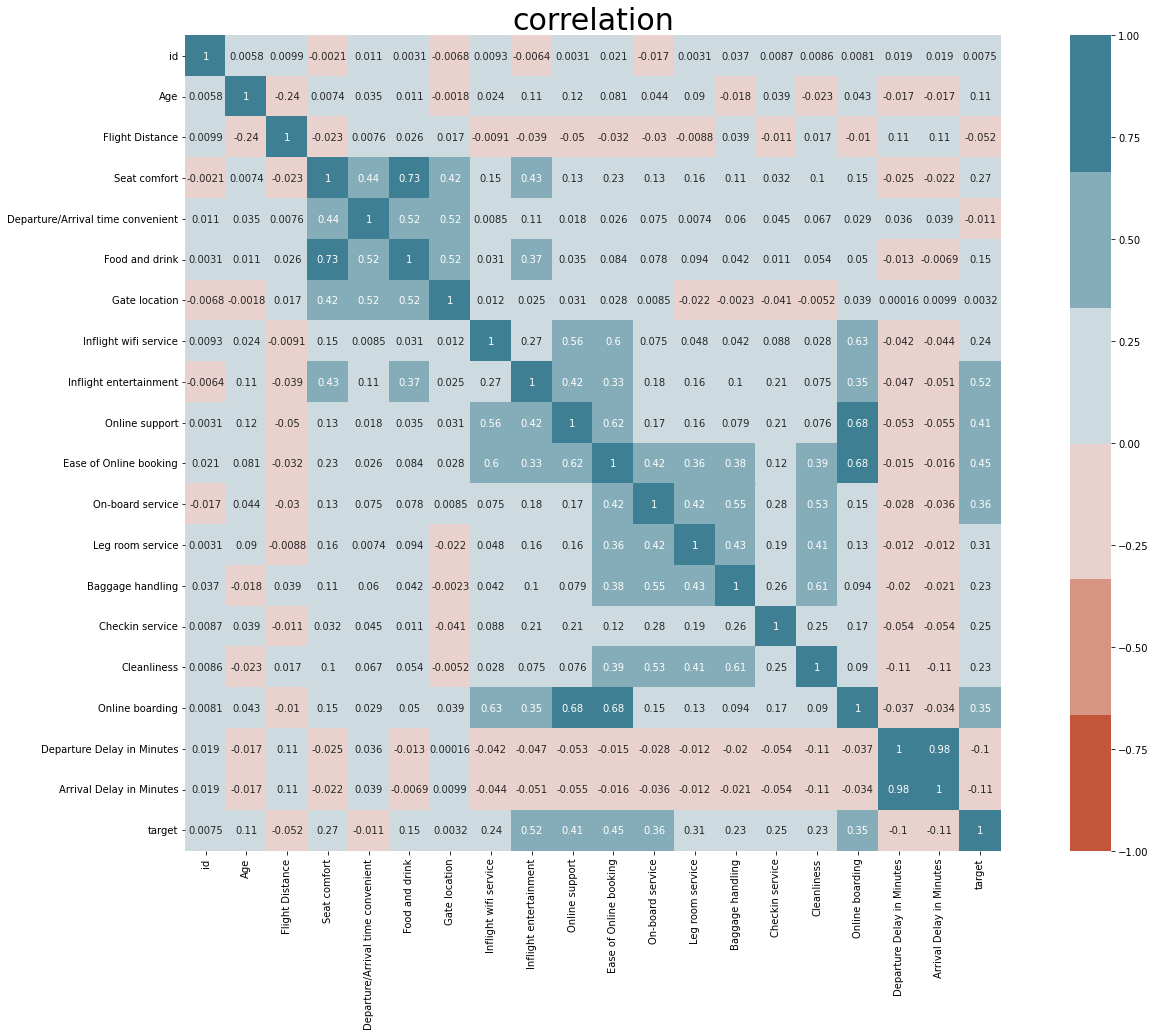

In [24]:
number_train = train.select_dtypes(np.number)

corr = number_train.corr()
plt.figure(figsize=(25, 15)) # 가로, 세로 

ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, # 상관계수의 범위
    cmap=sns.diverging_palette(20, 220), #색상을 변화시킵니다.
    square=True, 
    annot=True
)

#ax.set_xticklabels(ax.get_xticklabels(),rotation = 30) # x label 회전

plt.title('correlation', fontsize=30)
plt.show()

# 분포

## 1. 전체 분포
- 출발 지연 시간(Departure Delay in Minutes), 도착 지연 시간(Arrival Delay in Minutes): 왼쪽으로 치우친 분포
- 기내 와이파이 서비스 만족도(Inflight wifi service): 0인 경우는 거의 없음 
- 기내 엔터테인먼트 만족도(Inflight entertainment): 오른쪽으로 치우친 분포

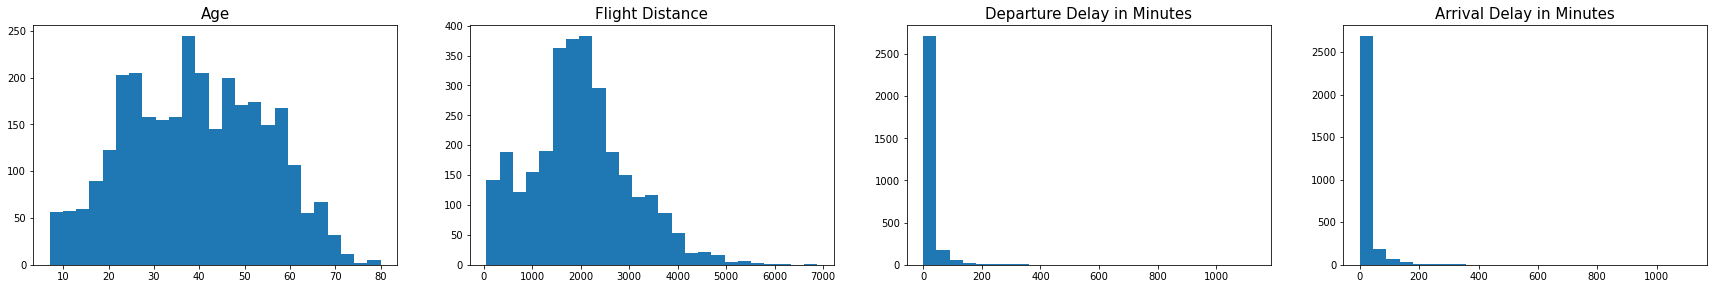

In [25]:
col_list = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes'] 
plt.figure(figsize=(30, 15)) # 가로, 세로 

for i in range(len(col_list)):
  col = col_list[i]

  plt.subplot(3, 4, i+1)
  plt.hist(train[col], bins = 25)
  plt.title(col, fontsize=15)

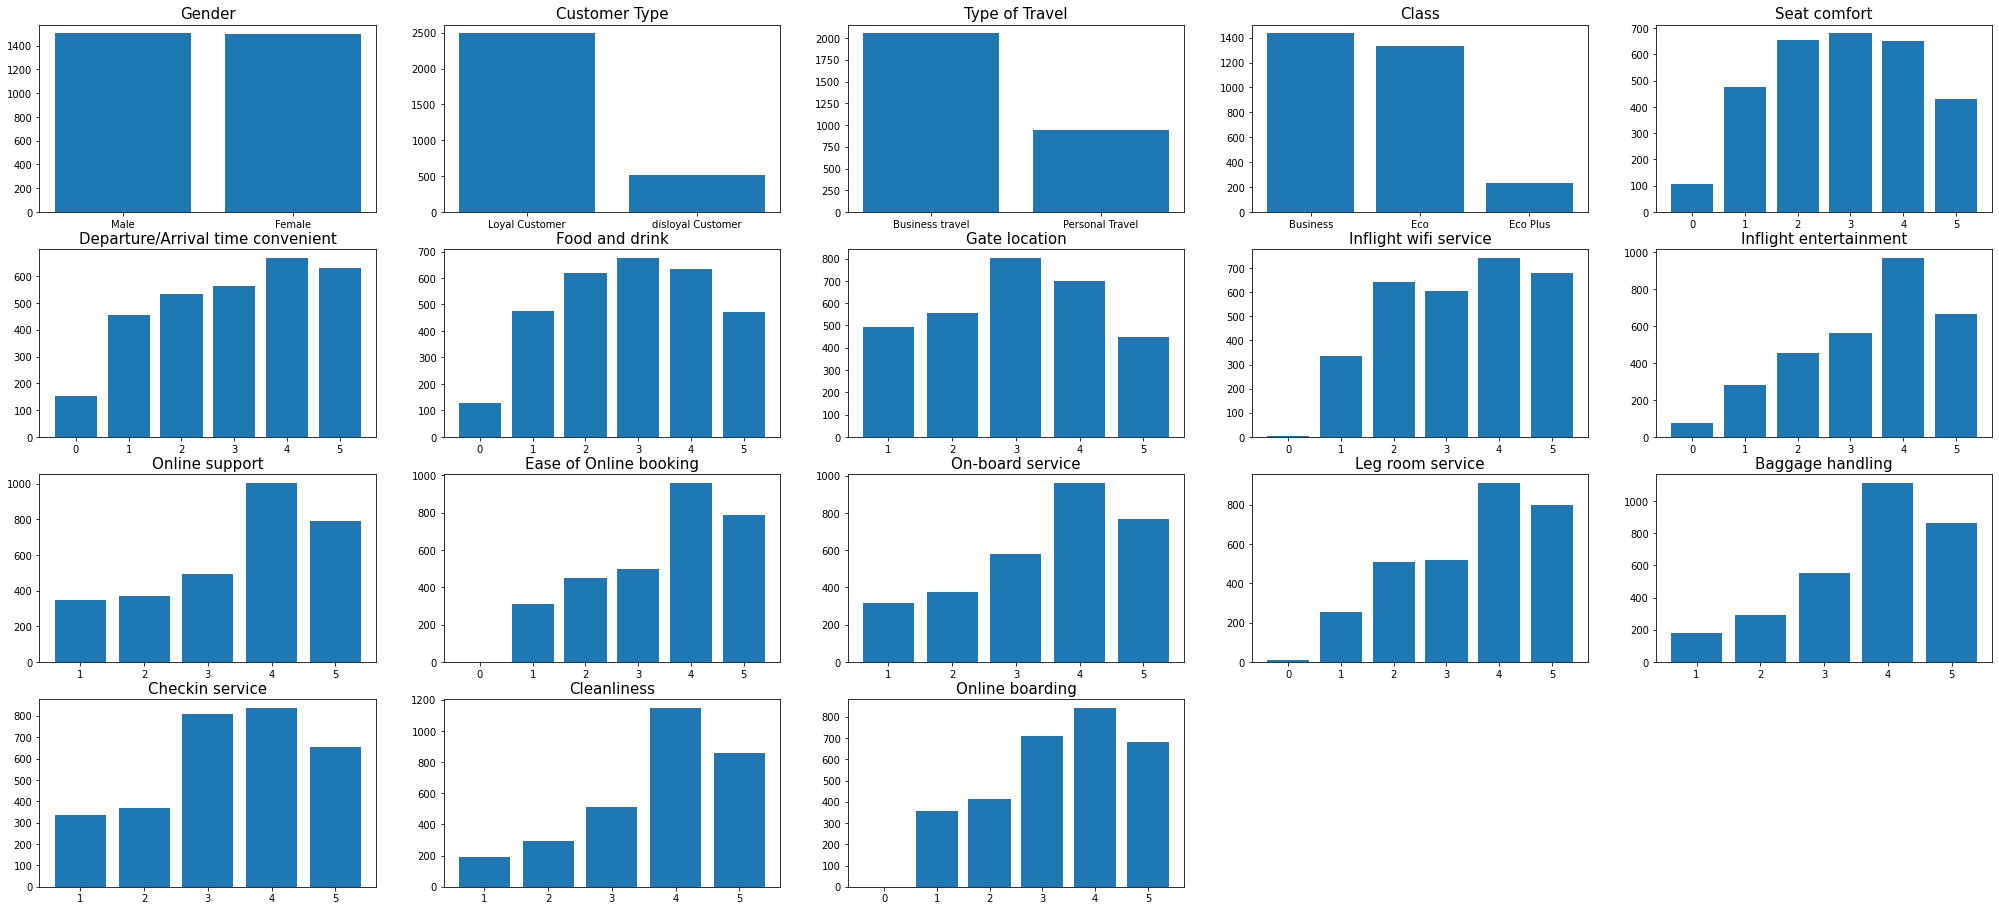

In [26]:
col_list = ['Gender', 'Customer Type', 'Type of Travel', 'Class',
            'Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 'Gate location', 
            'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking',
            'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 
            'Cleanliness', 'Online boarding',
           ]

plt.figure(figsize=(35, 20)) # 가로, 세로 

for i in range(len(col_list)):
  col = col_list[i]
  vc = train[col].value_counts()

  plt.subplot(5, 5, i+1)
  plt.bar(vc.keys(), vc.values)
  plt.xticks(vc.keys())
  plt.title(col, fontsize=15)

## 2. target 0일때 분포
- 좌석 만족도(Seat comfort)의 분포는 대부분 1에서 4 사이의 값을 가짐 

- 기내 엔터테인먼트 만족도(Inflight entertainment)의 분포는 대부분 1에서 4 사이의 값을 가짐 

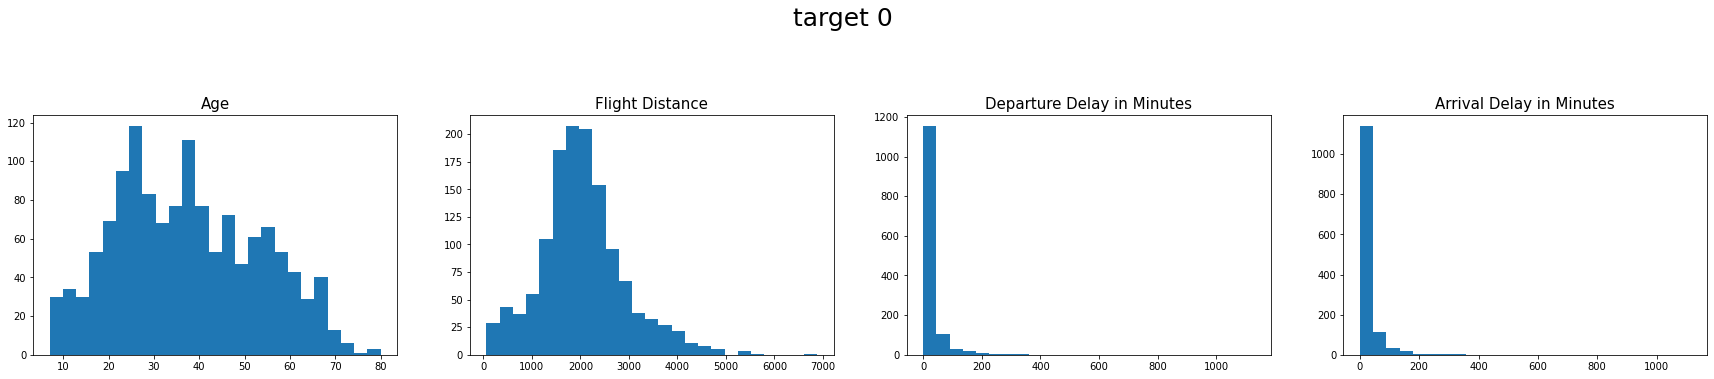

In [27]:
col_list = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes'] 
train_t0 = train[train.target == 0]

plt.figure(figsize=(30, 15)) # 가로, 세로 
plt.suptitle('target 0', fontsize= 25)

for i in range(len(col_list)):
  col = col_list[i]

  plt.subplot(3, 4, i+1)
  plt.hist(train_t0[col], bins = 25)
  plt.title(col, fontsize=15)

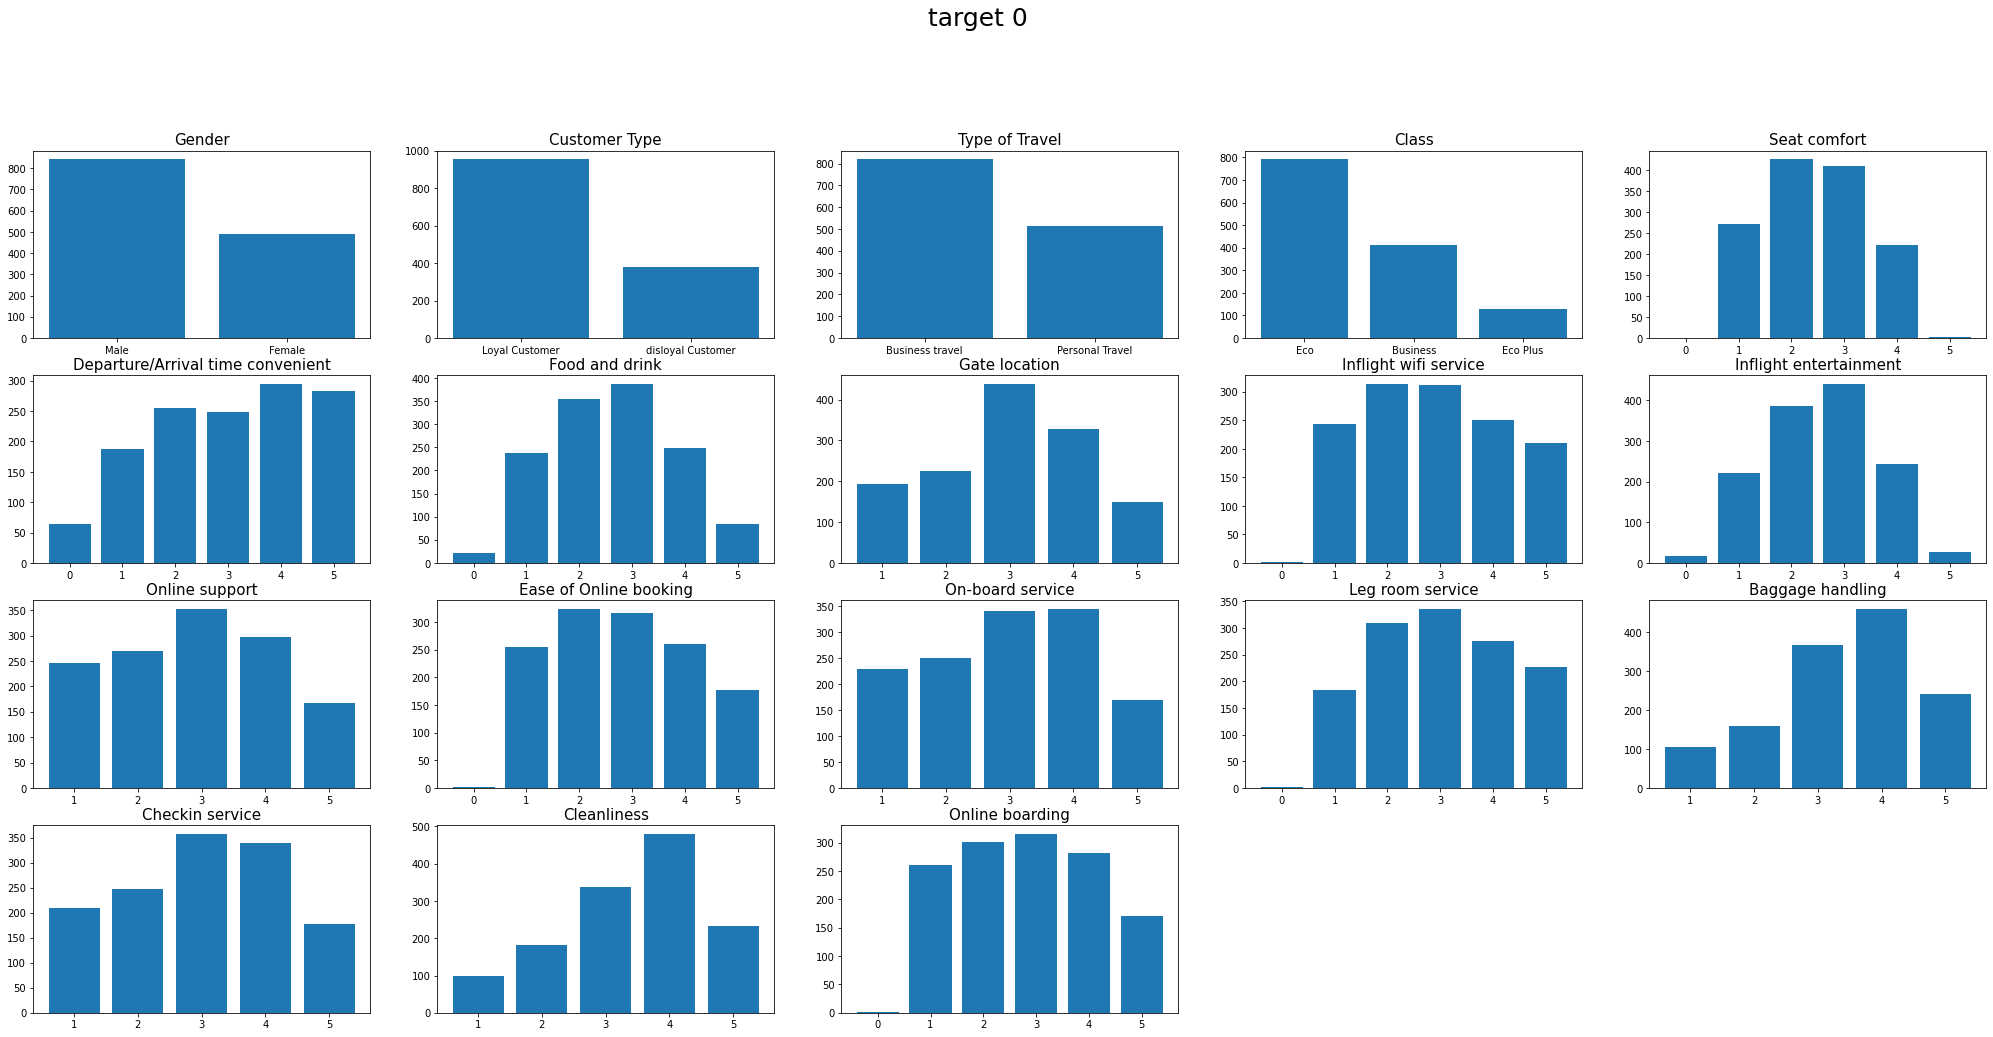

In [28]:
col_list = ['Gender', 'Customer Type', 'Type of Travel', 'Class',
            'Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 'Gate location', 
            'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking',
            'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 
            'Cleanliness', 'Online boarding',
           ]
train_t0 = train[train.target == 0]

plt.figure(figsize=(35, 20)) # 가로, 세로 
plt.suptitle('target 0', fontsize= 25)

for i in range(len(col_list)):
  col = col_list[i]
  vc = train_t0[col].value_counts()

  plt.subplot(5, 5, i+1)
  plt.bar(vc.keys(), vc.values)
  plt.xticks(vc.keys())
  plt.title(col, fontsize=15)

## 3. target 1일때 분포
- 좌석 만족도(Seat comfort)의 경우 4,5가 눈에 띄게 많음

- 기내 엔터테인먼트 만족도(Inflight entertainment)의 경우 4,5가 눈에 띄게 많음

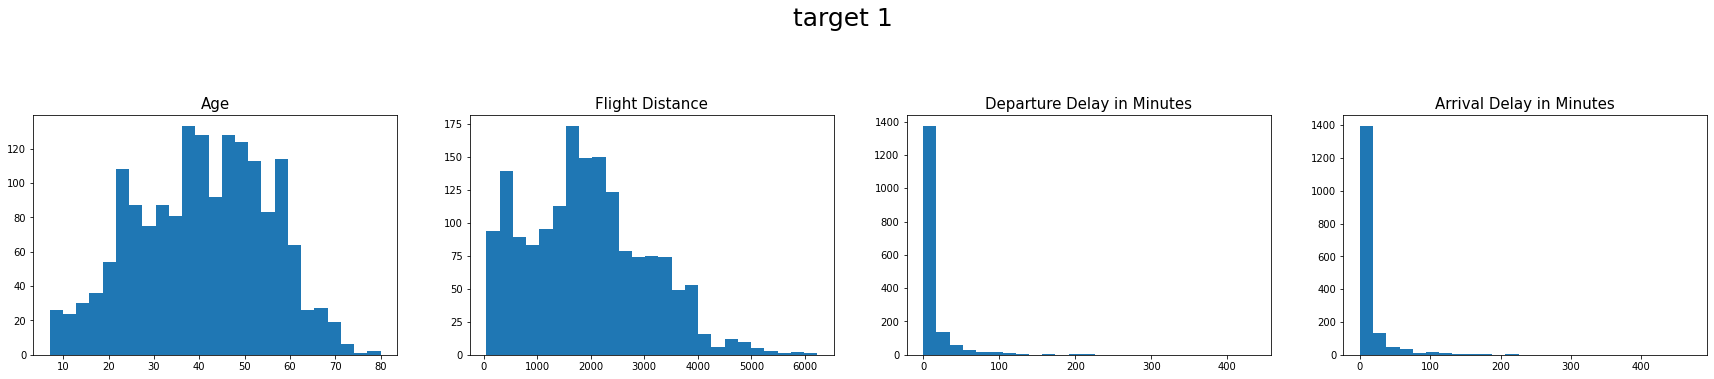

In [29]:
col_list = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes'] 
train_t1 = train[train.target == 1]

plt.figure(figsize=(30, 15)) # 가로, 세로 
plt.suptitle('target 1', fontsize= 25)

for i in range(len(col_list)):
  col = col_list[i]

  plt.subplot(3, 4, i+1)
  plt.hist(train_t1[col], bins = 25)
  plt.title(col, fontsize=15)

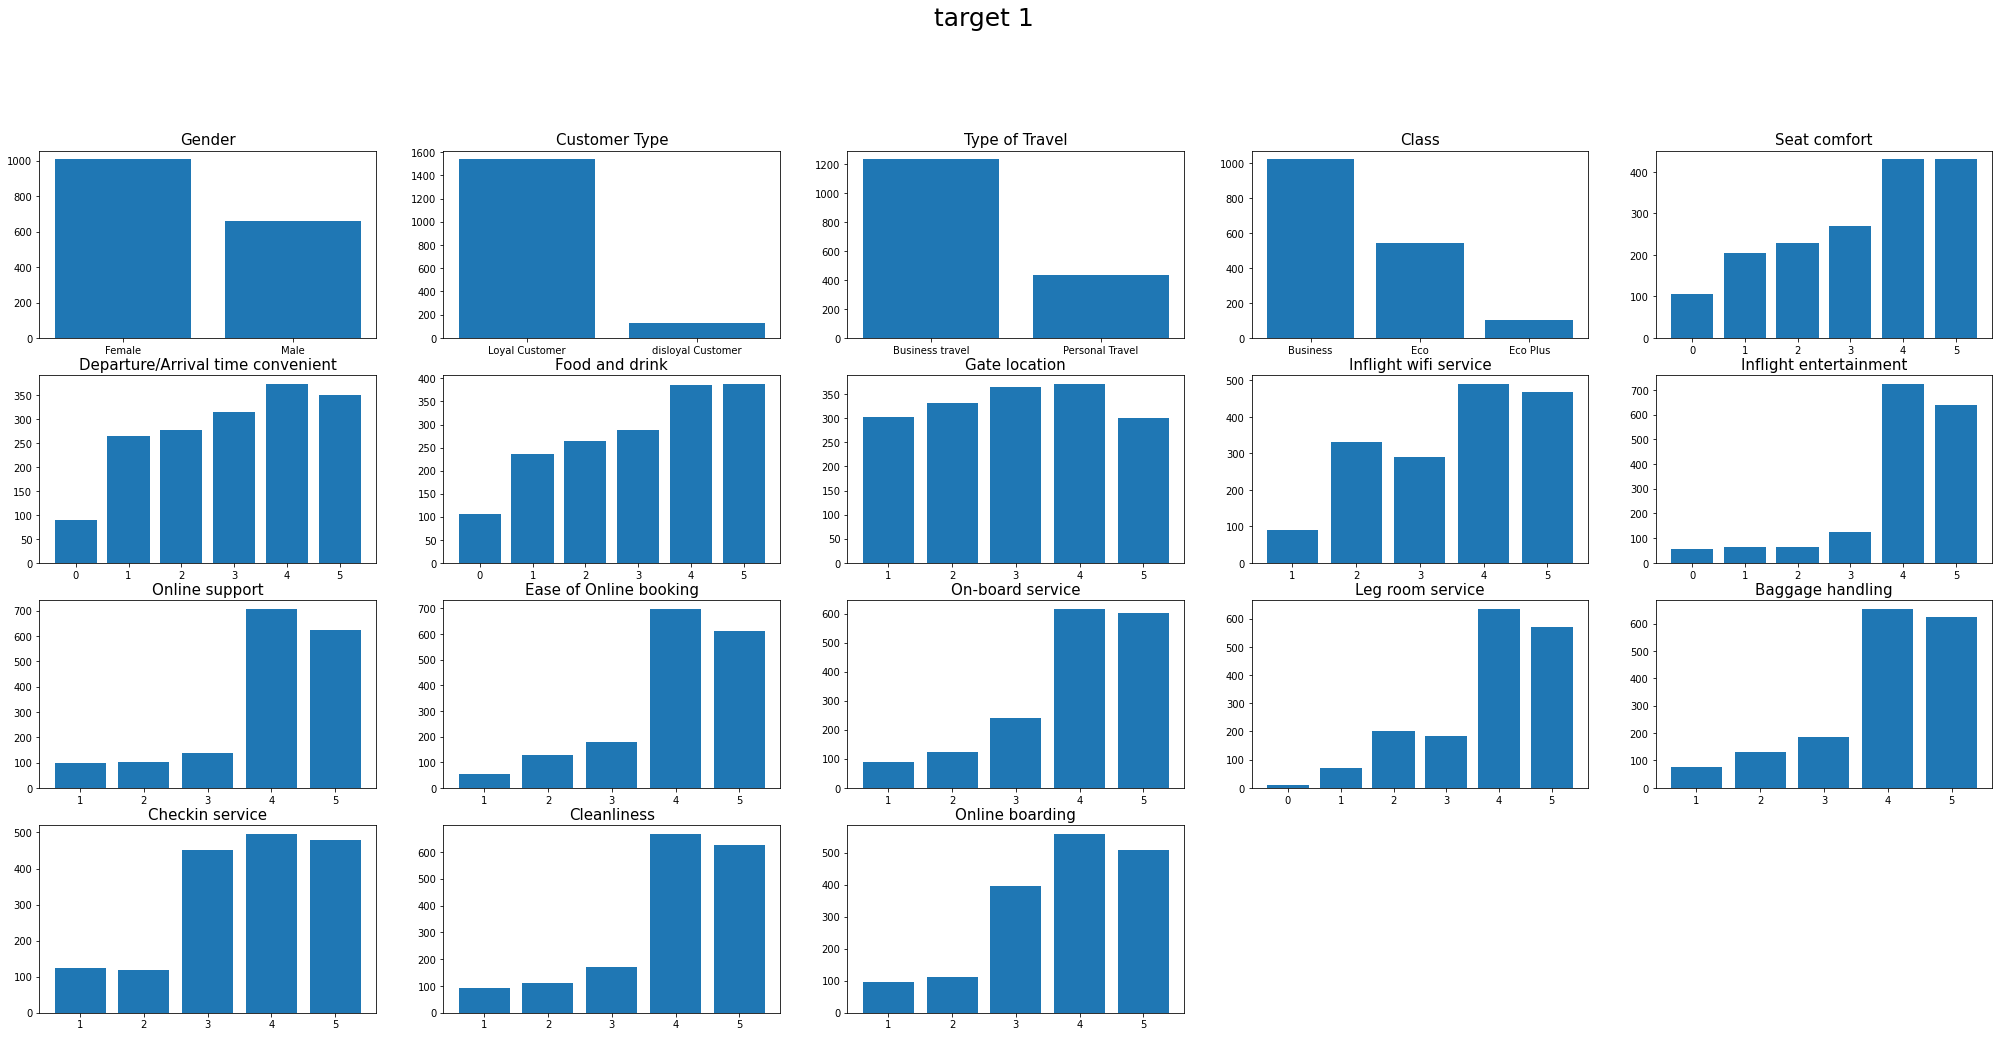

In [30]:
col_list = ['Gender', 'Customer Type', 'Type of Travel', 'Class',
            'Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 'Gate location', 
            'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking',
            'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 
            'Cleanliness', 'Online boarding',
           ]
train_t1 = train[train.target == 1]

plt.figure(figsize=(35, 20)) # 가로, 세로 
plt.suptitle('target 1', fontsize= 25)

for i in range(len(col_list)):
  col = col_list[i]
  vc = train_t1[col].value_counts()

  plt.subplot(5, 5, i+1)
  plt.bar(vc.keys(), vc.values)
  plt.xticks(vc.keys())
  plt.title(col, fontsize=15)

# Boxplot

## 1. target 구분 X
- 기내 엔터테인먼트 만족도(Inflight entertainment)의 경우 높은 중앙값을 가짐

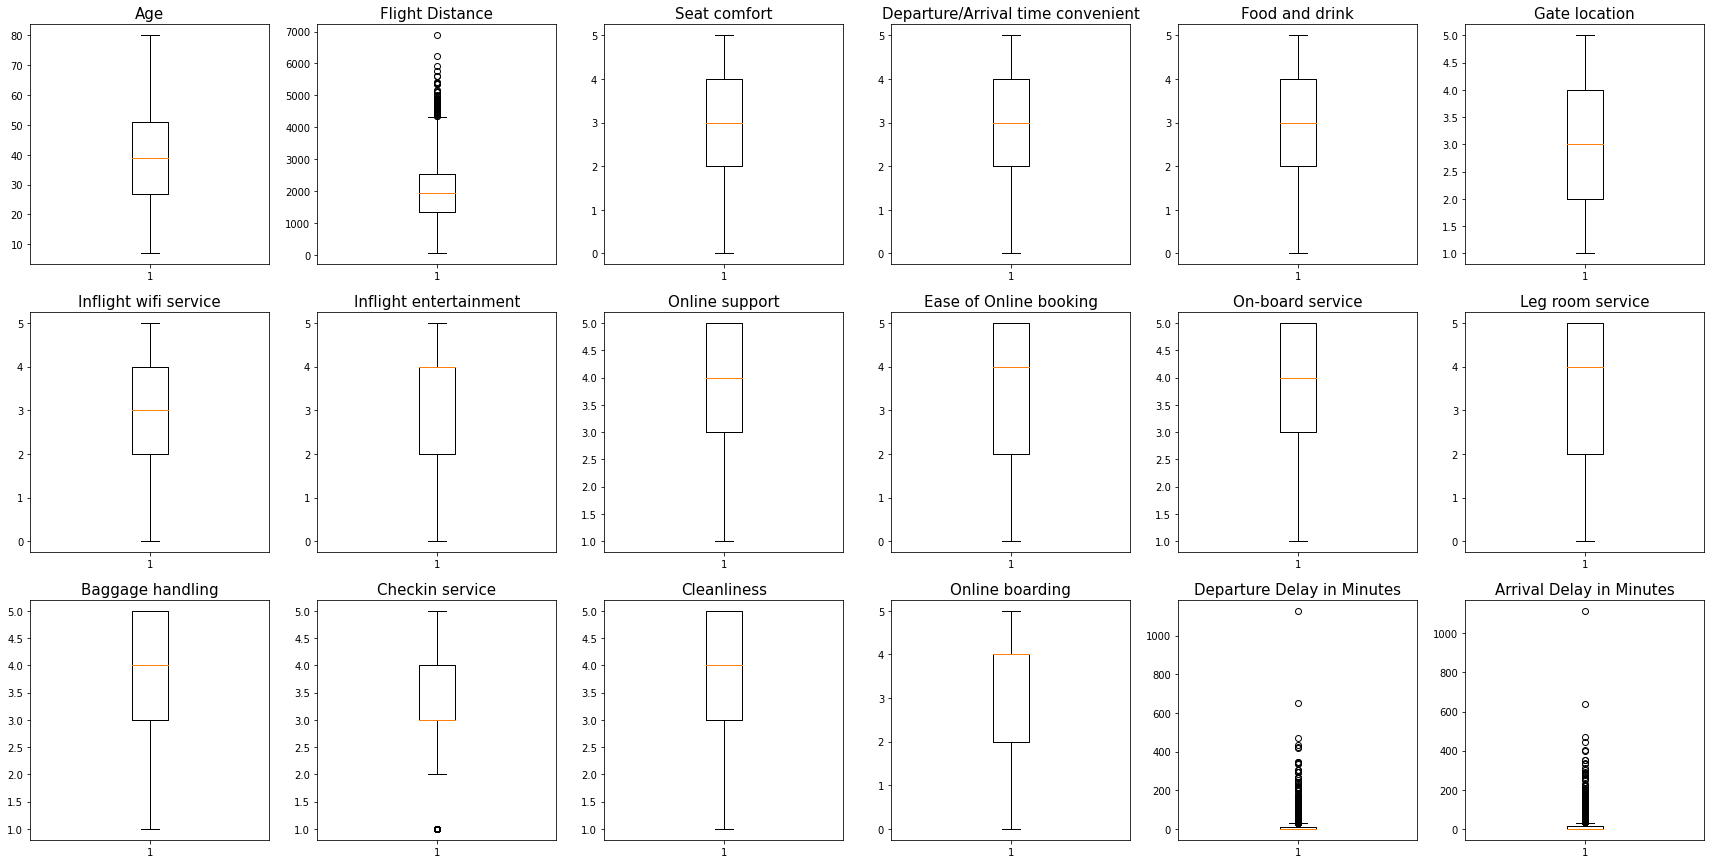

In [31]:
col_list = ['Age', 'Flight Distance', 'Seat comfort', 'Departure/Arrival time convenient','Food and drink', 'Gate location', 
            'Inflight wifi service','Inflight entertainment', 'Online support', 'Ease of Online booking','On-board service', 'Leg room service', 
            'Baggage handling','Checkin service', 'Cleanliness', 'Online boarding','Departure Delay in Minutes', 'Arrival Delay in Minutes'] 

plt.figure(figsize=(30, 15)) # 가로, 세로 

for i in range(len(col_list)):
  col = col_list[i]

  plt.subplot(3, 6, i+1)
  plt.boxplot(train[col])
  plt.title(col, fontsize=15)

## 2. target 구분 O

- 좌석 만족도(Seat comfort)에서 target에 따라 분위수 차이를 보임 

- 기내 엔터테인먼트 만족도(Inflight entertainment)에서 target에 따라 분위수 차이를 보임 

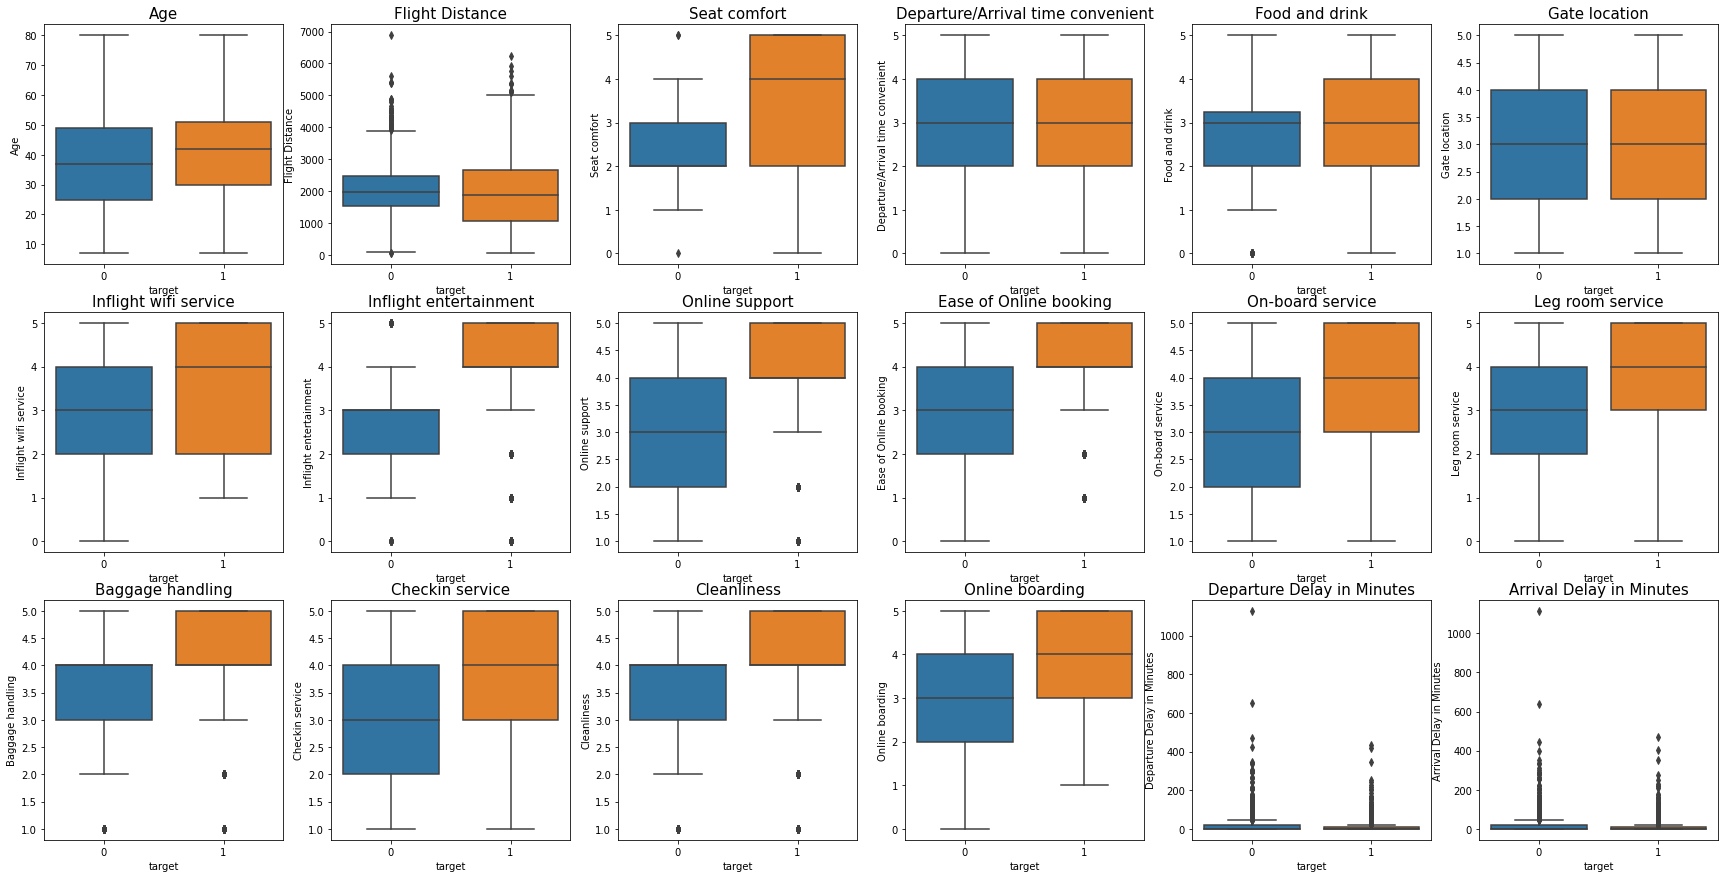

In [32]:
col_list = ['Age', 'Flight Distance', 'Seat comfort', 'Departure/Arrival time convenient','Food and drink', 'Gate location', 
            'Inflight wifi service','Inflight entertainment', 'Online support', 'Ease of Online booking','On-board service', 'Leg room service', 
            'Baggage handling','Checkin service', 'Cleanliness', 'Online boarding','Departure Delay in Minutes', 'Arrival Delay in Minutes'] 

plt.figure(figsize=(30, 15)) # 가로, 세로 

for i in range(len(col_list)):
  col = col_list[i]

  plt.subplot(3, 6, i+1)
  sns.boxplot(x = train['target'] , y = train[col])
  plt.title(col, fontsize=15)

# EDA 결과 요약

- 높은 상관관계 

  - 좌석 만족도(Seat comfort)와 식음료 만족도(Food and drink)

  - 온라인 지원 만족도(Online support)와 온라인보딩 만족도(Online boarding)

  - 온라인 예매 편리성 만족도(Ease of Online booking)와 온라인보딩 만족도(Online boarding)

  - 출발 지연 시간(Departure Delay in Minutes)과 도착 지연 시간(Arrival Delay in Minutes)

- 좌석 만족도(Seat comfort)와 기내 엔터테인먼트 만족도(Inflight entertainment)가 target에 많은 영향을 줄 것으로 보임

- 비행 거리(Flight Distance), 출발 지연 시간(Departure Delay in Minutes), 도착 지연 시간(Arrival Delay in Minutes): 많은 이상치 발견

# 전처리

## 1. data set 생성

In [33]:
#train
x_train = train.drop(['id','target'], axis=1)
y_train = train['target']

#test
x_test = test.drop(['id'], axis=1)

#shape 
print('x_train:', x_train.shape, 'y_train:', y_train.shape)
print('x_test:', x_test.shape)

x_train: (3000, 22) y_train: (3000,)
x_test: (2000, 22)


## 2. One-Hot Encoding

In [34]:
x_train = pd.get_dummies(data = x_train, columns = ['Gender', 'Customer Type', 'Type of Travel', 'Class'])
x_test = pd.get_dummies(data = x_test, columns = ['Gender', 'Customer Type', 'Type of Travel', 'Class'])

In [35]:
x_train.head()

,Age,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus
0,22,1599,3,0,3,3,4,3,4,4,5,4,4,4,5,4,0,0.0,1,0,0,1,1,0,0,1,0
1,37,2810,2,4,4,4,1,4,3,5,5,4,2,1,5,2,18,18.0,1,0,1,0,1,0,1,0,0
2,46,2622,1,1,1,1,4,5,5,4,4,4,4,5,4,3,0,0.0,0,1,1,0,1,0,1,0,0
3,24,2348,3,3,3,3,3,3,3,3,2,4,5,3,4,3,10,2.0,1,0,0,1,1,0,0,1,0
4,58,105,3,3,3,3,4,4,5,4,4,4,4,4,4,5,0,0.0,1,0,1,0,1,0,1,0,0


In [36]:
x_test.head()

,Age,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus
0,61,2037,1,1,1,1,3,5,5,5,5,5,5,3,5,3,51,58.0,1,0,1,0,0,1,0,1,0
1,27,1846,1,1,1,4,1,1,1,1,3,4,5,4,4,1,0,0.0,1,0,0,1,1,0,1,0,0
2,52,1622,4,4,4,4,4,3,4,5,5,5,5,4,5,3,0,0.0,1,0,1,0,1,0,1,0,0
3,54,3534,4,4,4,4,5,4,5,2,2,2,2,5,2,1,0,0.0,0,1,1,0,1,0,1,0,0
4,41,1471,4,3,3,3,4,4,4,4,3,1,2,5,4,4,0,0.0,1,0,1,0,1,0,0,1,0


## 3. 출발 지연 시간(Departure Delay in Minutes), 도착 지연 시간(Arrival Delay in Minutes)
- 상관관계가 높았던 점을 고려해 평균값으로 대체

In [37]:
x_train['Delay in Minutes'] = (x_train['Departure Delay in Minutes'] + x_train['Arrival Delay in Minutes']) / 2 
x_test['Delay in Minutes'] = (x_test['Departure Delay in Minutes'] + x_test['Arrival Delay in Minutes']) / 2 

#drop
x_train = x_train.drop(['Departure Delay in Minutes', 'Arrival Delay in Minutes'], axis=1)
x_test = x_test.drop(['Departure Delay in Minutes', 'Arrival Delay in Minutes'], axis=1)

## 4. 표준화

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train[['Delay in Minutes']])

x_train['Delay in Minutes'] = scaler.transform(x_train[['Delay in Minutes']])
x_test['Delay in Minutes'] = scaler.transform(x_test[['Delay in Minutes']])

scaler = StandardScaler()
scaler.fit(x_train[['Flight Distance']])

x_train['Flight Distance'] = scaler.transform(x_train[['Flight Distance']])
x_test['Flight Distance'] = scaler.transform(x_test[['Flight Distance']])

# 모델링

## 1. K-Fold Cross-Validation

In [39]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

## 2. Random Forest

In [40]:
#모델 생성
model=RandomForestClassifier()

#최적화할 파라미터 범위 
rf_param = {'n_estimators': [500, 1000, 1500],
             'max_depth': [20, 25, 30],
             'min_samples_leaf' : [1, 2, 4],
             'min_samples_split' : [2, 4, 6]
             }

grid_rf = GridSearchCV(model, param_grid=rf_param, scoring = 'accuracy', cv=folds, n_jobs=-1)
grid_rf.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [20, 25, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [500, 1000, 1500]},
             scoring='accuracy')

In [41]:
print('best params:\n', grid_rf.best_params_)
print('best score:', grid_rf.best_score_)

best params:
 {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1500}
best score: 0.925


## 3. XGBoost

In [42]:
#모델 생성
model=XGBClassifier()

#최적화할 파라미터 범위 
xgb_param = {'learning_rate': [0.05, 0.1, 0.2],
             'n_estimator': [25, 50, 100],
             'max_depth': [6, 8, 10]
             }

grid_xgb = GridSearchCV(model, param_grid=xgb_param, scoring = 'accuracy', cv=folds, n_jobs=-1)
grid_xgb.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [6, 8, 10],
                         'n_estimator': [25, 50, 100]},
             scoring='accuracy')

In [43]:
print('best params:\n', grid_xgb.best_params_)
print('best score:', grid_xgb.best_score_)

best params:
 {'learning_rate': 0.2, 'max_depth': 8, 'n_estimator': 25}
best score: 0.9263333333333333


## 4. LGBM

In [44]:
#모델 생성
model=LGBMClassifier()

#최적화할 파라미터 범위 
lgbm_params = {'learning_rate': [0.05, 0.1, 0.2],
               'max_depth': [6, 8, 10],
               'n_estimator': [25, 50, 100]
              }
            

grid_lgbm = GridSearchCV(model, param_grid=lgbm_params, scoring = 'accuracy', cv=folds, n_jobs=-1)
grid_lgbm.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [6, 8, 10],
                         'n_estimator': [25, 50, 100]},
             scoring='accuracy')

In [45]:
print('best params:\n', grid_lgbm.best_params_)
print('best score:', grid_lgbm.best_score_)

best params:
 {'learning_rate': 0.1, 'max_depth': 10, 'n_estimator': 25}
best score: 0.9259999999999999


## 5. CatBoost

In [46]:
#모델 생성
model=CatBoostClassifier()

#최적화할 파라미터 범위 
cb_params = {'depth' : [6, 8, 10],
             'learning_rate' : [0.05, 0.1, 0.2],
             'iterations' : [100, 150, 200]
            }


grid_cb = GridSearchCV(model, param_grid=cb_params, scoring = 'accuracy', cv=folds, n_jobs=-1)
grid_cb.fit(x_train, y_train)

0:	learn: 0.5065756	total: 53.7ms	remaining: 5.32s
1:	learn: 0.4015222	total: 60.2ms	remaining: 2.95s
2:	learn: 0.3338388	total: 65.8ms	remaining: 2.13s
3:	learn: 0.2958887	total: 71.4ms	remaining: 1.71s
4:	learn: 0.2464021	total: 77.3ms	remaining: 1.47s
5:	learn: 0.2269602	total: 83ms	remaining: 1.3s
6:	learn: 0.2141518	total: 88.7ms	remaining: 1.18s
7:	learn: 0.1982013	total: 94.3ms	remaining: 1.08s
8:	learn: 0.1850720	total: 100ms	remaining: 1.01s
9:	learn: 0.1784366	total: 106ms	remaining: 950ms
10:	learn: 0.1697986	total: 112ms	remaining: 903ms
11:	learn: 0.1637443	total: 118ms	remaining: 862ms
12:	learn: 0.1535114	total: 123ms	remaining: 824ms
13:	learn: 0.1476031	total: 129ms	remaining: 794ms
14:	learn: 0.1430293	total: 135ms	remaining: 766ms
15:	learn: 0.1382317	total: 141ms	remaining: 741ms
16:	learn: 0.1355302	total: 147ms	remaining: 717ms
17:	learn: 0.1318929	total: 153ms	remaining: 696ms
18:	learn: 0.1260130	total: 159ms	remaining: 677ms
19:	learn: 0.1221892	total: 165ms	re

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x7fd763478650>,
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10], 'iterations': [100, 150, 200],
                         'learning_rate': [0.05, 0.1, 0.2]},
             scoring='accuracy')

In [47]:
print('best params:\n', grid_cb.best_params_)
print('best score:', grid_cb.best_score_)

best params:
 {'depth': 8, 'iterations': 100, 'learning_rate': 0.2}
best score: 0.9353333333333333


## 6. Soft Voting

In [48]:
estimators = [
            ('RF', grid_rf.best_estimator_),
            ('XGB', grid_xgb.best_estimator_),
            ('LGBM',grid_lgbm.best_estimator_),
            ('CB',grid_cb.best_estimator_)
            ]

sv_model = VotingClassifier(estimators=estimators, voting='soft')
sv_model.fit(x_train, y_train)

0:	learn: 0.5065756	total: 7.51ms	remaining: 744ms
1:	learn: 0.4015222	total: 13.9ms	remaining: 680ms
2:	learn: 0.3338388	total: 20ms	remaining: 646ms
3:	learn: 0.2958887	total: 26.1ms	remaining: 626ms
4:	learn: 0.2464021	total: 32ms	remaining: 609ms
5:	learn: 0.2269602	total: 38.2ms	remaining: 599ms
6:	learn: 0.2141518	total: 44ms	remaining: 585ms
7:	learn: 0.1982013	total: 49.7ms	remaining: 571ms
8:	learn: 0.1850720	total: 55.7ms	remaining: 563ms
9:	learn: 0.1784366	total: 61.7ms	remaining: 555ms
10:	learn: 0.1697986	total: 70.2ms	remaining: 568ms
11:	learn: 0.1637443	total: 76ms	remaining: 557ms
12:	learn: 0.1535114	total: 81.9ms	remaining: 548ms
13:	learn: 0.1476031	total: 87.9ms	remaining: 540ms
14:	learn: 0.1430293	total: 93.7ms	remaining: 531ms
15:	learn: 0.1382317	total: 99.5ms	remaining: 522ms
16:	learn: 0.1355302	total: 105ms	remaining: 514ms
17:	learn: 0.1318929	total: 111ms	remaining: 506ms
18:	learn: 0.1260130	total: 117ms	remaining: 499ms
19:	learn: 0.1221892	total: 123ms

VotingClassifier(estimators=[('RF',
                              RandomForestClassifier(max_depth=20,
                                                     n_estimators=1500)),
                             ('XGB',
                              XGBClassifier(learning_rate=0.2, max_depth=8,
                                            n_estimator=25)),
                             ('LGBM',
                              LGBMClassifier(max_depth=10, n_estimator=25)),
                             ('CB',
                              <catboost.core.CatBoostClassifier object at 0x7fd7654612d0>)],
                 voting='soft')

# 최종예측
- 예측 성능이 가장 좋았던 catboost 단일 모델 사용

In [49]:
model = CatBoostClassifier(**grid_cb.best_params_)
model.fit(x_train, y_train)

0:	learn: 0.5065756	total: 6ms	remaining: 594ms
1:	learn: 0.4015222	total: 12.5ms	remaining: 613ms
2:	learn: 0.3338388	total: 18.4ms	remaining: 595ms
3:	learn: 0.2958887	total: 24.4ms	remaining: 585ms
4:	learn: 0.2464021	total: 30.4ms	remaining: 578ms
5:	learn: 0.2269602	total: 36.2ms	remaining: 567ms
6:	learn: 0.2141518	total: 42ms	remaining: 558ms
7:	learn: 0.1982013	total: 48.5ms	remaining: 558ms
8:	learn: 0.1850720	total: 54.3ms	remaining: 549ms
9:	learn: 0.1784366	total: 60.3ms	remaining: 542ms
10:	learn: 0.1697986	total: 66.2ms	remaining: 535ms
11:	learn: 0.1637443	total: 72ms	remaining: 528ms
12:	learn: 0.1535114	total: 77.9ms	remaining: 521ms
13:	learn: 0.1476031	total: 84.5ms	remaining: 519ms
14:	learn: 0.1430293	total: 90.6ms	remaining: 514ms
15:	learn: 0.1382317	total: 96.4ms	remaining: 506ms
16:	learn: 0.1355302	total: 102ms	remaining: 498ms
17:	learn: 0.1318929	total: 108ms	remaining: 491ms
18:	learn: 0.1260130	total: 114ms	remaining: 485ms
19:	learn: 0.1221892	total: 120m

In [50]:
submission['target'] = model.predict(x_test)

In [51]:
print(submission)

        id  target
0        1       1
1        2       0
2        3       1
3        4       1
4        5       1
...    ...     ...
1995  1996       0
1996  1997       1
1997  1998       0
1998  1999       1
1999  2000       1

[2000 rows x 2 columns]


In [52]:
#submission.to_csv("catboost_sub.csv",index=False)